In [1]:
import os
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

In [2]:
import pandas as pd
import numpy as np

def select_random_time(df, datetime_col):
    """
    Select a random datetime from a DataFrame column, excluding the first and last 100 days.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the datetime data.
    datetime_col (str): The column name containing datetime data.
    
    Returns:
    datetime: A random datetime value from the DataFrame, excluding the first and last 100 days.
    """
    # Convert the datetime column to datetime type if not already
    df[datetime_col] = pd.to_datetime(df[datetime_col])

    # Sort the DataFrame by the datetime column
    df_sorted = df.sort_values(by=datetime_col)

    # Determine the dates to exclude
    start_date = df_sorted[datetime_col].iloc[0] + pd.Timedelta(days=100)
    end_date = df_sorted[datetime_col].iloc[-1] - pd.Timedelta(days=100)

    # Filter the DataFrame to exclude the first and last 100 days
    df_filtered = df_sorted[(df_sorted[datetime_col] >= start_date) & (df_sorted[datetime_col] <= end_date)]

    # Select a random datetime from the filtered DataFrame
    if not df_filtered.empty:
        random_time = np.random.choice(df_filtered[datetime_col])
        return random_time
    else:
        return None  # In case the filtered DataFrame is empty

# Example usage:
# Assuming turbine_df is your DataFrame and "# Date and time" is the column with datetime data.
# random_datetime = select_random_time(turbine_df, "# Date and time")
# print("Random datetime selected:", random_datetime)



In [3]:
years  = ["2016_3082","2017_3083","2018_3084","2019_3085","2020_3086","2021_3087"]

folderheader = "5841834/Kelmarsh_SCADA_"
turbine_data_header = "/Turbine_Data_Kelmarsh"
status_header = "/Status_Kelmarsh"

In [4]:
years  = ["2016_3082","2017_3083","2018_3084","2019_3085","2020_3086","2021_3087"]

folderheader = "5841834/Kelmarsh_SCADA_"
turbine_data_header = "/Turbine_Data_Kelmarsh"
status_header = "/Status_Kelmarsh"

def process_files(years, folderheader, keyword):
    dataframes = []
    for year in years:
        # List all files in the directory for the given year
        files = os.listdir(folderheader + year)
        # Filter files based on the keyword
        filtered_files = [file for file in files if keyword in file]
        
        for filename in filtered_files:
            # Extract the turbine number from the filename
            turbine_number = filename.split('_')[-5]
            # Construct the full file path
            filepath = os.path.join(folderheader+year, filename)
            # Read the CSV file
            df = pd.read_csv(filepath, header=9)
            # Add a column for the turbine number
            df['Turbine'] = turbine_number
            # Append the dataframe to the list
            dataframes.append(df)
    
    # Concatenate all dataframes into one and reset the index
    return pd.concat(dataframes, ignore_index=True)

# Usage

status_df = process_files(years, folderheader, 'Status')
turbine_df = process_files(years, folderheader, 'Turbine')

In [5]:
status_df['Timestamp start'] = pd.to_datetime(status_df['Timestamp start'])
turbine_df["# Date and time"] = pd.to_datetime(turbine_df["# Date and time"])


In [6]:
relevant_errors = ["Pitch run-away (hub box v.>=4)",
"Frequency converter error",
"Overload generator fan 1"]


In [7]:
fc_errors = status_df[status_df["Message"]=="Frequency converter error"].loc[:,["Timestamp start", "Turbine"]].reset_index()

In [8]:
def remove_duplicates_based_on_date_and_turbine(df, timestamp_col, turbine_id_col):
    """
    Remove duplicates from a DataFrame based on the same day and turbine identifier.

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    timestamp_col (str): The name of the column containing timestamp data.
    turbine_id_col (str): The name of the column containing turbine identifiers.

    Returns:
    pd.DataFrame: A DataFrame with duplicates removed based on day and turbine identifier.
    """

    # Ensure the timestamp column is in datetime format
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Extract the date from the timestamp
    df['date'] = df[timestamp_col].dt.date

    # Drop duplicates based on 'date' and turbine identifier
    df_unique = df.drop_duplicates(subset=['date', turbine_id_col])

    # Optionally, drop the 'date' column if no longer needed
    df_unique = df_unique.drop(columns=['date'])

    return df_unique


fc_errors = remove_duplicates_based_on_date_and_turbine(fc_errors, "Timestamp start", "Turbine")

In [9]:
fc_errors

,index,Timestamp start,Turbine
0,70,2016-01-29 10:08:33,2
1,77,2016-01-30 07:33:38,2
2,81,2016-02-01 18:43:27,2
3,83,2016-02-02 16:04:36,2
5,1892,2016-02-14 11:12:49,3
6,4730,2016-02-22 13:18:07,6
7,4757,2016-02-23 19:49:02,6
8,7920,2016-02-04 20:03:42,5
9,7921,2016-02-05 07:39:46,5
11,10012,2016-01-24 16:51:17,1


In [10]:
df = fc_errors
# Assuming 'df' is your DataFrame
# First, make sure the 'date' column is in datetime format
df['date'] = df['Timestamp start'].dt.date

# Sort the DataFrame by 'Turbine' and 'date'
df = df.sort_values(by=['Turbine', 'date'])


# Check for consecutive messages for the same turbine on consecutive days
df['duplicate'] = df.duplicated(subset=['Turbine'], keep='first') & \
                  (df['date'] - df['date'].shift() == pd.Timedelta(days=1)) & \
                  (df['Turbine'] == df['Turbine'].shift())

# Keep only the non-duplicate entries
df = df[~df['duplicate']]

# Drop the 'duplicate' column as it's no longer needed
df.drop(columns=['duplicate'], inplace=True)

# Reset the index of the DataFrame if needed
df.reset_index(drop=True, inplace=True)

In [11]:
fc_errors = df

In [12]:
fc_errors

,index,Timestamp start,Turbine,date
0,10012,2016-01-24 16:51:17,1,2016-01-24
1,10157,2016-03-01 18:35:40,1,2016-03-01
2,70,2016-01-29 10:08:33,2,2016-01-29
3,81,2016-02-01 18:43:27,2,2016-02-01
4,64048,2018-03-14 10:50:34,2,2018-03-14
5,72499,2018-12-17 15:40:51,2,2018-12-17
6,1892,2016-02-14 11:12:49,3,2016-02-14
7,90818,2018-04-20 05:31:19,3,2018-04-20
8,230649,2020-10-24 12:09:21,3,2020-10-24
9,132687,2018-11-02 17:58:41,4,2018-11-02


In [13]:
relevant_features = ['# Date and time', 'Turbine', 'Long Term Wind (m/s)',
       'Potential power reference turbines (kW)', 'Energy Export (kWh)',
       'Available Capacity for Production (kW)', 'Time-based System Avail.',
       'Energy Import (kWh)', 'Power (kW)', 'Grid frequency (Hz)',
       'Grid voltage (V)', 'Apparent power (kVA)', 'Reactive power (kvar)',
       'Wind speed (m/s)', 'Lost Production (Time-based IEC B.2.4) (kWh)',
       'Voltage L2 / V (V)', 'Voltage L1 / U (V)', 'Voltage L3 / W (V)',
       'Current L1 / U (A)', 'Current L2 / V (A)', 'Current L3 / W (A)',
       'Temp. top box (°C)', 'Wind direction (°)', 'Rotor bearing temp (°C)',
       'Hub temperature (°C)', 'Generator RPM (RPM)',
       'Stator temperature 1 (°C)', 'Grid current (A)',
       'Generator bearing rear temperature (°C)', 'Nacelle position (°)',
       'Generator bearing front temperature (°C)',
       'Ambient temperature (converter) (°C)', 'Rotor speed (RPM)',
       'Drive train acceleration (mm/ss)',
       'Blade angle (pitch position) C (°)',
       'Nacelle ambient temperature (°C)',
       'Blade angle (pitch position) A (°)', 'Gear oil temperature (°C)',
       'Transformer cell temperature (°C)', 'Gear oil inlet temperature (°C)',
       'Gearbox speed (RPM)', 'Front bearing temperature (°C)',
       'Yaw bearing angle (°)', 'Blade angle (pitch position) B (°)',
       'Nacelle temperature (°C)', 'Transformer temperature (°C)',
       'Rear bearing temperature (°C)', 'Energy Export counter (kWh)']

In [14]:
turbine_df = turbine_df[relevant_features]

In [15]:
# Mean imputation for each column
for column in turbine_df.select_dtypes(include=['float64', 'int64']):
    mean_value = turbine_df[column].mean()
    turbine_df[column].fillna(mean_value, inplace=True)

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/3269051480.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  turbine_df[column].fillna(mean_value, inplace=True)


In [16]:
turbine_df

,# Date and time,Turbine,Long Term Wind (m/s),Potential power reference turbines (kW),Energy Export (kWh),Available Capacity for Production (kW),Time-based System Avail.,Energy Import (kWh),Power (kW),Grid frequency (Hz),...,Transformer cell temperature (°C),Gear oil inlet temperature (°C),Gearbox speed (RPM),Front bearing temperature (°C),Yaw bearing angle (°),Blade angle (pitch position) B (°),Nacelle temperature (°C),Transformer temperature (°C),Rear bearing temperature (°C),Energy Export counter (kWh)
0,2016-01-03 00:00:00,5,7.1,659.782717,99.138302,1987.247974,0.969389,0.053251,600.462665,49.988252,...,16.252906,47.837793,1238.075564,65.343041,200.398863,6.219527,20.979968,48.904777,64.046748,1.390673e+07
1,2016-01-03 00:10:00,5,7.1,659.782717,99.138302,1987.247974,0.969389,0.053251,600.462665,49.988252,...,16.252906,47.837793,1238.075564,65.343041,200.398863,6.219527,20.979968,48.904777,64.046748,1.390673e+07
2,2016-01-03 00:20:00,5,7.1,659.782717,99.138302,1987.247974,0.969389,0.053251,600.462665,49.988252,...,16.252906,47.837793,1238.075564,65.343041,200.398863,6.219527,20.979968,48.904777,64.046748,1.390673e+07
3,2016-01-03 00:30:00,5,7.1,659.782717,99.138302,1987.247974,0.969389,0.053251,600.462665,49.988252,...,16.252906,47.837793,1238.075564,65.343041,200.398863,6.219527,20.979968,48.904777,64.046748,1.390673e+07
4,2016-01-03 00:40:00,5,7.1,659.782717,99.138302,1987.247974,0.969389,0.053251,600.462665,49.988252,...,16.252906,47.837793,1238.075564,65.343041,200.398863,6.219527,20.979968,48.904777,64.046748,1.390673e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733179,2021-06-30 23:10:00,4,5.3,69.078587,8.000000,2050.000000,1.000000,0.000000,62.040001,49.939999,...,16.252906,47.837793,1238.075564,65.343041,200.398863,6.219527,20.979968,48.904777,64.046748,1.390673e+07
1733180,2021-06-30 23:20:00,4,5.3,120.135275,19.000000,2050.000000,1.000000,0.000000,104.099998,49.970001,...,16.252906,47.837793,1238.075564,65.343041,200.398863,6.219527,20.979968,48.904777,64.046748,1.390673e+07
1733181,2021-06-30 23:30:00,4,5.3,162.238598,17.000000,2050.000000,1.000000,0.000000,107.620003,49.970001,...,16.252906,47.837793,1238.075564,65.343041,200.398863,6.219527,20.979968,48.904777,64.046748,1.390673e+07
1733182,2021-06-30 23:40:00,4,5.3,124.528406,10.000000,2050.000000,1.000000,0.000000,55.610001,49.950001,...,16.252906,47.837793,1238.075564,65.343041,200.398863,6.219527,20.979968,48.904777,64.046748,1.390673e+07


In [17]:

# Ensure datetime formats
fc_errors['Timestamp start'] = pd.to_datetime(fc_errors['Timestamp start'])
turbine_df['# Date and time'] = pd.to_datetime(turbine_df['# Date and time'])

# Initialize a list to hold the result
results_rest = []
results_mean = []
results_std = []

# Loop through each row in fc_errors
for index, row in fc_errors.iterrows():
    # Filter turbine_df for the same turbine and the 24-hour period before the timestamp
    mask = (turbine_df['Turbine'] == row['Turbine']) & \
           (turbine_df['# Date and time'] >= row['Timestamp start'] - pd.Timedelta(hours=48)) & \
           (turbine_df['# Date and time'] < row['Timestamp start']- pd.Timedelta(hours=24))
    filtered_df = turbine_df[mask]

    # Calculate mean and std for each feature in filtered_df
    mean_values = filtered_df[relevant_features[2:]].mean()  
    std_values = filtered_df[relevant_features[2:]].std()
    rest_values = filtered_df[relevant_features[:2]].iloc[-1]


    # Append results including the index from fc_errors for reference
    results_mean.append(mean_values)
    results_std.append(std_values)
    results_rest.append(rest_values)

## Convert results into a DataFrame for easier handling
#result_df = pd.DataFrame(results)


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_mean]

# Concatenate all DataFrame rows into a single DataFrame
results_mean_df = pd.concat(dataframes, ignore_index=True)

results_mean_df.columns= ['mean_' + col for col in results_mean_df.columns]


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_std]

# Concatenate all DataFrame rows into a single DataFrame
results_std_df = pd.concat(dataframes, ignore_index=True)

results_std_df.columns= ['std_' + col for col in results_std_df.columns]

# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_rest]

# Concatenate all DataFrame rows into a single DataFrame
results_rest_df = pd.concat(dataframes, ignore_index=True)

final_df = pd.concat([results_mean_df, results_std_df, results_rest_df], axis=1)
final_df['error'] = 1

In [117]:

# Ensure datetime formats
fc_errors['Timestamp start'] = pd.to_datetime(fc_errors['Timestamp start'])
turbine_df['# Date and time'] = pd.to_datetime(turbine_df['# Date and time'])

# Initialize a list to hold the result
results_rest = []
results_mean = []
results_std = []

# Loop through each row in fc_errors
for index, row in fc_errors.iterrows():
    # Filter turbine_df for the same turbine and the 24-hour period before the timestamp
    mask = (turbine_df['Turbine'] == row['Turbine']) & \
           (turbine_df['# Date and time'] >= row['Timestamp start'] - pd.Timedelta(hours=72)) & \
           (turbine_df['# Date and time'] < row['Timestamp start']- pd.Timedelta(hours=48))
    filtered_df = turbine_df[mask]

    # Calculate mean and std for each feature in filtered_df
    mean_values = filtered_df[relevant_features[2:]].mean()  
    std_values = filtered_df[relevant_features[2:]].std()
    rest_values = filtered_df[relevant_features[:2]].iloc[-1]


    # Append results including the index from fc_errors for reference
    results_mean.append(mean_values)
    results_std.append(std_values)
    results_rest.append(rest_values)

## Convert results into a DataFrame for easier handling
#result_df = pd.DataFrame(results)


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_mean]

# Concatenate all DataFrame rows into a single DataFrame
results_mean_df = pd.concat(dataframes, ignore_index=True)

results_mean_df.columns= ['mean_' + col for col in results_mean_df.columns]


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_std]

# Concatenate all DataFrame rows into a single DataFrame
results_std_df = pd.concat(dataframes, ignore_index=True)

results_std_df.columns= ['std_' + col for col in results_std_df.columns]

# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_rest]

# Concatenate all DataFrame rows into a single DataFrame
results_rest_df = pd.concat(dataframes, ignore_index=True)

test_df_72 = pd.concat([results_mean_df, results_std_df, results_rest_df], axis=1)

In [118]:

# Ensure datetime formats
fc_errors['Timestamp start'] = pd.to_datetime(fc_errors['Timestamp start'])
turbine_df['# Date and time'] = pd.to_datetime(turbine_df['# Date and time'])

# Initialize a list to hold the result
results_rest = []
results_mean = []
results_std = []

# Loop through each row in fc_errors
for index, row in fc_errors.iterrows():
    # Filter turbine_df for the same turbine and the 24-hour period before the timestamp
    mask = (turbine_df['Turbine'] == row['Turbine']) & \
           (turbine_df['# Date and time'] >= row['Timestamp start'] - pd.Timedelta(hours=96)) & \
           (turbine_df['# Date and time'] < row['Timestamp start']- pd.Timedelta(hours=72))
    filtered_df = turbine_df[mask]

    # Calculate mean and std for each feature in filtered_df
    mean_values = filtered_df[relevant_features[2:]].mean()  
    std_values = filtered_df[relevant_features[2:]].std()
    rest_values = filtered_df[relevant_features[:2]].iloc[-1]


    # Append results including the index from fc_errors for reference
    results_mean.append(mean_values)
    results_std.append(std_values)
    results_rest.append(rest_values)

## Convert results into a DataFrame for easier handling
#result_df = pd.DataFrame(results)


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_mean]

# Concatenate all DataFrame rows into a single DataFrame
results_mean_df = pd.concat(dataframes, ignore_index=True)

results_mean_df.columns= ['mean_' + col for col in results_mean_df.columns]


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_std]

# Concatenate all DataFrame rows into a single DataFrame
results_std_df = pd.concat(dataframes, ignore_index=True)

results_std_df.columns= ['std_' + col for col in results_std_df.columns]

# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_rest]

# Concatenate all DataFrame rows into a single DataFrame
results_rest_df = pd.concat(dataframes, ignore_index=True)

test_df_96 = pd.concat([results_mean_df, results_std_df, results_rest_df], axis=1)

In [149]:

# Ensure datetime formats
fc_errors['Timestamp start'] = pd.to_datetime(fc_errors['Timestamp start'])
turbine_df['# Date and time'] = pd.to_datetime(turbine_df['# Date and time'])

# Initialize a list to hold the result
results_rest = []
results_mean = []
results_std = []

# Loop through each row in fc_errors
for index, row in fc_errors.iterrows():
    # Filter turbine_df for the same turbine and the 24-hour period before the timestamp
    mask = (turbine_df['Turbine'] == row['Turbine']) & \
           (turbine_df['# Date and time'] >= row['Timestamp start'] - pd.Timedelta(hours=120)) & \
           (turbine_df['# Date and time'] < row['Timestamp start']- pd.Timedelta(hours=96))
    filtered_df = turbine_df[mask]

    # Calculate mean and std for each feature in filtered_df
    mean_values = filtered_df[relevant_features[2:]].mean()  
    std_values = filtered_df[relevant_features[2:]].std()
    rest_values = filtered_df[relevant_features[:2]].iloc[-1]


    # Append results including the index from fc_errors for reference
    results_mean.append(mean_values)
    results_std.append(std_values)
    results_rest.append(rest_values)

## Convert results into a DataFrame for easier handling
#result_df = pd.DataFrame(results)


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_mean]

# Concatenate all DataFrame rows into a single DataFrame
results_mean_df = pd.concat(dataframes, ignore_index=True)

results_mean_df.columns= ['mean_' + col for col in results_mean_df.columns]


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_std]

# Concatenate all DataFrame rows into a single DataFrame
results_std_df = pd.concat(dataframes, ignore_index=True)

results_std_df.columns= ['std_' + col for col in results_std_df.columns]

# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_rest]

# Concatenate all DataFrame rows into a single DataFrame
results_rest_df = pd.concat(dataframes, ignore_index=True)

test_df_120 = pd.concat([results_mean_df, results_std_df, results_rest_df], axis=1)

In [150]:

# Ensure datetime formats
fc_errors['Timestamp start'] = pd.to_datetime(fc_errors['Timestamp start'])
turbine_df['# Date and time'] = pd.to_datetime(turbine_df['# Date and time'])

# Initialize a list to hold the result
results_rest = []
results_mean = []
results_std = []

# Loop through each row in fc_errors
for index, row in fc_errors.iterrows():
    # Filter turbine_df for the same turbine and the 24-hour period before the timestamp
    mask = (turbine_df['Turbine'] == row['Turbine']) & \
           (turbine_df['# Date and time'] >= row['Timestamp start'] - pd.Timedelta(hours=144)) & \
           (turbine_df['# Date and time'] < row['Timestamp start']- pd.Timedelta(hours=120))
    filtered_df = turbine_df[mask]

    # Calculate mean and std for each feature in filtered_df
    mean_values = filtered_df[relevant_features[2:]].mean()  
    std_values = filtered_df[relevant_features[2:]].std()
    rest_values = filtered_df[relevant_features[:2]].iloc[-1]


    # Append results including the index from fc_errors for reference
    results_mean.append(mean_values)
    results_std.append(std_values)
    results_rest.append(rest_values)

## Convert results into a DataFrame for easier handling
#result_df = pd.DataFrame(results)


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_mean]

# Concatenate all DataFrame rows into a single DataFrame
results_mean_df = pd.concat(dataframes, ignore_index=True)

results_mean_df.columns= ['mean_' + col for col in results_mean_df.columns]


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_std]

# Concatenate all DataFrame rows into a single DataFrame
results_std_df = pd.concat(dataframes, ignore_index=True)

results_std_df.columns= ['std_' + col for col in results_std_df.columns]

# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_rest]

# Concatenate all DataFrame rows into a single DataFrame
results_rest_df = pd.concat(dataframes, ignore_index=True)

test_df_144 = pd.concat([results_mean_df, results_std_df, results_rest_df], axis=1)

In [18]:

# Ensure datetime formats
fc_errors['Timestamp start'] = pd.to_datetime(fc_errors['Timestamp start'])
turbine_df['# Date and time'] = pd.to_datetime(turbine_df['# Date and time'])

# Initialize a list to hold the result
results_rest = []
results_mean = []
results_std = []

# Loop through each row in fc_errors
for i in range(200):
    turbine = np.random.choice(["1","2","3","4","5","6"])
    time_stamp = select_random_time(turbine_df[turbine_df.Turbine==turbine],'# Date and time')
    
    # Filter turbine_df for the same turbine and the 24-hour period before the timestamp
    mask = (turbine_df['Turbine'] == turbine) & \
           (turbine_df['# Date and time'] >= time_stamp - pd.Timedelta(hours=48)) & \
           (turbine_df['# Date and time'] < time_stamp- pd.Timedelta(hours=24))
    filtered_df = turbine_df[mask]

    # Calculate mean and std for each feature in filtered_df
    mean_values = filtered_df[relevant_features[2:]].mean()  
    std_values = filtered_df[relevant_features[2:]].std()
    rest_values = filtered_df[relevant_features[:2]].iloc[-1]


    # Append results including the index from fc_errors for reference
    results_mean.append(mean_values)
    results_std.append(std_values)
    results_rest.append(rest_values)

## Convert results into a DataFrame for easier handling
#result_df = pd.DataFrame(results)


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_mean]

# Concatenate all DataFrame rows into a single DataFrame
results_mean_df = pd.concat(dataframes, ignore_index=True)

results_mean_df.columns= ['mean_' + col for col in results_mean_df.columns]


# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_std]

# Concatenate all DataFrame rows into a single DataFrame
results_std_df = pd.concat(dataframes, ignore_index=True)

results_std_df.columns= ['std_' + col for col in results_std_df.columns]

# Convert each Series to a DataFrame and transpose
dataframes = [s.to_frame().T for s in results_rest]

# Concatenate all DataFrame rows into a single DataFrame
results_rest_df = pd.concat(dataframes, ignore_index=True)

final_df_non_error = pd.concat([results_mean_df, results_std_df, results_rest_df], axis=1)
final_df_non_error['error'] = 0

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_col] = pd.to_datetime(df[datetime_col])
/var/folders/4y/3ynvczrn5fldxkh3r7m_fh8r0000gn/T/ipykernel_69049/252147257.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [19]:
final_df_non_error

,mean_Long Term Wind (m/s),mean_Potential power reference turbines (kW),mean_Energy Export (kWh),mean_Available Capacity for Production (kW),mean_Time-based System Avail.,mean_Energy Import (kWh),mean_Power (kW),mean_Grid frequency (Hz),mean_Grid voltage (V),mean_Apparent power (kVA),...,std_Front bearing temperature (°C),std_Yaw bearing angle (°),std_Blade angle (pitch position) B (°),std_Nacelle temperature (°C),std_Transformer temperature (°C),std_Rear bearing temperature (°C),std_Energy Export counter (kWh),# Date and time,Turbine,error
0,5.7,378.538451,61.381944,2050.000000,1.000000,0.069444,369.287610,49.995095,401.774046,426.503091,...,6.639560e+00,20.300862,8.776653e+00,2.025025e+00,2.377839,5.231944e+00,2.444988e+03,2017-09-09 08:00:00,5,0
1,5.7,940.633362,161.222222,2050.000000,1.000000,0.000000,968.185834,49.977292,695.305695,1033.240972,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2016-04-11 13:40:00,5,0
2,7.0,263.772187,83.055556,2050.000000,1.000000,0.000000,497.509524,49.985052,402.219244,537.449892,...,3.153405e+00,17.305109,7.099550e-02,2.993189e+00,5.509379,2.375317e+00,3.578266e+03,2016-12-02 06:00:00,3,0
3,6.5,1055.044601,0.136037,0.000000,0.000000,0.001879,600.462665,49.988252,419.493306,647.960348,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2018-10-28 16:00:00,5,0
4,6.5,133.107703,14.369599,2050.000000,1.000000,0.229380,84.696407,49.993715,401.578701,126.303046,...,9.986853e+00,39.609510,1.992761e+01,2.134456e+00,1.110538,9.747887e+00,2.110943e+06,2019-10-24 04:10:00,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5.2,65.105388,4.480556,2033.248843,0.991829,0.429253,24.147773,50.003828,403.649651,68.636836,...,4.422295e+00,60.398367,1.874237e+01,3.880853e+00,2.413155,4.645792e+00,8.663964e+05,2018-07-14 04:20:00,3,0
196,6.5,1119.176514,0.201571,0.000000,0.000000,0.001145,600.462665,49.988252,419.493306,647.960348,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2018-10-28 09:10:00,2,0
197,5.3,1683.282870,295.472222,2050.000000,1.000000,0.001582,1773.657535,49.990148,402.503469,1843.138586,...,8.965157e-01,7.165488,3.077558e+00,1.854150e+00,11.383056,1.240940e+00,1.295537e+04,2020-06-29 23:20:00,2,0
198,5.7,621.206848,141.618056,2050.000000,1.000000,0.002066,850.136814,49.985477,402.923918,903.928116,...,2.706761e+00,8.866924,3.244993e-01,4.693223e+00,13.917303,2.091658e+00,6.181407e+03,2020-09-13 21:30:00,5,0


In [20]:
final_df

,mean_Long Term Wind (m/s),mean_Potential power reference turbines (kW),mean_Energy Export (kWh),mean_Available Capacity for Production (kW),mean_Time-based System Avail.,mean_Energy Import (kWh),mean_Power (kW),mean_Grid frequency (Hz),mean_Grid voltage (V),mean_Apparent power (kVA),...,std_Front bearing temperature (°C),std_Yaw bearing angle (°),std_Blade angle (pitch position) B (°),std_Nacelle temperature (°C),std_Transformer temperature (°C),std_Rear bearing temperature (°C),std_Energy Export counter (kWh),# Date and time,Turbine,error
0,7.10,689.258265,85.186838,164.640625,0.080313,0.125860,515.759003,49.991868,475.341809,555.481875,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2016-01-23 16:50:00,1,1
1,6.90,91.276042,16.041667,2050.000000,1.000000,0.229167,94.693263,49.998958,697.783264,104.928681,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2016-02-29 18:30:00,1,1
2,7.10,590.471257,264.381944,2050.000000,1.000000,0.000000,1584.988746,49.994306,700.282708,1585.594866,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2016-01-28 10:00:00,2,1
3,7.10,659.782717,0.000000,0.000000,0.000000,0.083333,-2.173125,49.986597,696.910003,2.173472,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2016-01-31 18:40:00,2,1
4,6.40,555.937974,112.902778,2050.000000,1.000000,0.006944,680.174161,49.974587,403.071682,713.803475,...,3.875270e+00,88.793608,3.194393e-01,3.370532e+00,10.737355,3.132672e+00,5.765307e+03,2018-03-13 10:50:00,2,1
5,7.00,1095.539541,180.902778,2050.000000,1.000000,0.003300,1083.194422,49.988275,401.060426,1130.783565,...,2.809220e+00,28.976764,2.087084e+00,5.032980e+00,26.002511,2.197930e+00,7.716458e+03,2018-12-16 15:40:00,2,1
6,6.90,417.964183,69.534722,2050.000000,1.000000,0.000000,417.565835,49.990833,700.860761,429.897639,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2016-02-13 11:10:00,3,1
7,5.70,871.758115,110.083333,2046.725694,0.998403,0.001502,659.188043,49.987249,401.595208,721.599003,...,2.802932e+00,23.876743,3.815068e+00,3.176633e+00,13.976390,2.113141e+00,5.112587e+03,2018-04-19 05:30:00,3,1
8,6.50,442.698765,49.923611,2050.000000,1.000000,0.041324,298.704543,49.986030,401.829038,364.156797,...,5.000451e+00,25.921497,5.307346e+00,2.488497e+00,4.219773,3.288212e+00,1.183390e+06,2020-10-23 12:00:00,3,1
9,6.65,573.423354,0.181164,0.000000,0.000000,0.000578,600.462665,49.988252,419.493306,647.960348,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2018-11-01 17:50:00,4,1


In [21]:
ges_df = pd.concat([final_df_non_error,final_df])

In [22]:
ges_df

,mean_Long Term Wind (m/s),mean_Potential power reference turbines (kW),mean_Energy Export (kWh),mean_Available Capacity for Production (kW),mean_Time-based System Avail.,mean_Energy Import (kWh),mean_Power (kW),mean_Grid frequency (Hz),mean_Grid voltage (V),mean_Apparent power (kVA),...,std_Front bearing temperature (°C),std_Yaw bearing angle (°),std_Blade angle (pitch position) B (°),std_Nacelle temperature (°C),std_Transformer temperature (°C),std_Rear bearing temperature (°C),std_Energy Export counter (kWh),# Date and time,Turbine,error
0,5.70,378.538451,61.381944,2050.00000,1.000000,0.069444,369.287610,49.995095,401.774046,426.503091,...,6.639560e+00,20.300862,8.776653e+00,2.025025e+00,2.377839,5.231944e+00,2.444988e+03,2017-09-09 08:00:00,5,0
1,5.70,940.633362,161.222222,2050.00000,1.000000,0.000000,968.185834,49.977292,695.305695,1033.240972,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2016-04-11 13:40:00,5,0
2,7.00,263.772187,83.055556,2050.00000,1.000000,0.000000,497.509524,49.985052,402.219244,537.449892,...,3.153405e+00,17.305109,7.099550e-02,2.993189e+00,5.509379,2.375317e+00,3.578266e+03,2016-12-02 06:00:00,3,0
3,6.50,1055.044601,0.136037,0.00000,0.000000,0.001879,600.462665,49.988252,419.493306,647.960348,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2018-10-28 16:00:00,5,0
4,6.50,133.107703,14.369599,2050.00000,1.000000,0.229380,84.696407,49.993715,401.578701,126.303046,...,9.986853e+00,39.609510,1.992761e+01,2.134456e+00,1.110538,9.747887e+00,2.110943e+06,2019-10-24 04:10:00,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,6.65,573.423354,0.181164,0.00000,0.000000,0.000578,600.462665,49.988252,419.493306,647.960348,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2018-11-01 17:50:00,4,1
10,5.40,958.325596,151.131944,2050.00000,1.000000,0.001919,906.292211,50.001535,402.944654,946.554189,...,2.239366e+00,30.194043,8.971955e-01,1.522167e+00,12.444318,1.512466e+00,7.057162e+03,2020-08-20 07:00:00,4,1
11,6.90,982.242360,200.895833,1880.49537,0.917315,0.055556,1205.368749,49.983681,700.512153,1208.881318,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2016-02-03 20:00:00,5,1
12,6.90,1682.462360,275.243056,2050.00000,1.000000,0.000000,1651.511178,49.986597,723.040831,1751.033540,...,1.426046e-14,0.000000,8.912785e-16,3.565114e-15,0.000000,1.426046e-14,1.869147e-09,2016-02-21 13:10:00,6,1


In [23]:
X = ges_df.iloc[:,:-3]

In [33]:
from scipy.stats import zscore

# Apply the zscore function to compute the z-scores for each column in X
X_scaled = X.apply(zscore)

In [48]:
X_scaled

,mean_Long Term Wind (m/s),mean_Potential power reference turbines (kW),mean_Energy Export (kWh),mean_Available Capacity for Production (kW),mean_Time-based System Avail.,mean_Energy Import (kWh),mean_Power (kW),mean_Grid frequency (Hz),mean_Grid voltage (V),mean_Apparent power (kVA),...,std_Transformer cell temperature (°C),std_Gear oil inlet temperature (°C),std_Gearbox speed (RPM),std_Front bearing temperature (°C),std_Yaw bearing angle (°),std_Blade angle (pitch position) B (°),std_Nacelle temperature (°C),std_Transformer temperature (°C),std_Rear bearing temperature (°C),std_Energy Export counter (kWh)
0,-0.689149,-0.616848,-0.472559,0.250411,0.250411,0.141173,-0.511598,0.393415,-0.225334,-0.480642,...,-0.005792,-0.765798,0.350907,0.423982,-0.493736,0.040533,-0.511573,-0.755763,0.216373,-0.497449
1,-0.689149,0.471456,0.682166,0.250411,0.250411,-0.691727,0.664004,-1.033427,4.935665,0.677808,...,-1.914915,-2.166422,-1.658674,-1.256991,-1.000753,-0.893350,-2.566558,-1.076271,-1.176237,-0.499308
2,1.265861,-0.839054,-0.221888,0.250411,0.250411,-0.691727,-0.259906,-0.411444,-0.217506,-0.268811,...,-1.223971,0.714261,-0.308018,-0.458627,-0.568556,-0.885796,0.470914,-0.333664,-0.543988,-0.496587
3,0.513934,0.692974,-1.180913,-4.747511,-4.747511,-0.669196,-0.057815,-0.155014,0.086214,-0.057812,...,-1.914915,-2.166422,-1.658674,-1.256991,-1.000753,-0.893350,-2.566558,-1.076271,-1.176237,-0.499308
4,0.513934,-1.092041,-1.016291,0.250411,0.250411,2.059405,-1.070234,0.282847,-0.228769,-1.053817,...,-0.085697,0.626162,1.380235,1.271434,-0.011501,1.227056,-0.400523,-0.926582,1.418401,1.105524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,0.739512,-0.239520,-1.180391,-4.747511,-4.747511,-0.684794,-0.057815,-0.155014,0.086214,-0.057812,...,-1.914915,-2.166422,-1.658674,-1.256991,-1.000753,-0.893350,-2.566558,-1.076271,-1.176237,-0.499308
10,-1.140305,0.505711,0.565465,0.250411,0.250411,-0.668706,0.542510,0.909614,-0.204752,0.512296,...,-0.461513,0.101184,-0.303002,-0.690039,-0.246653,-0.797884,-1.021871,0.601093,-0.773657,-0.493943
11,1.115475,0.552018,1.141021,-0.162843,-0.162843,-0.025407,1.129580,-0.521371,5.027207,1.013159,...,-1.914915,-2.166422,-1.658674,-1.256991,-1.000753,-0.893350,-2.566558,-1.076271,-1.176237,-0.499308
12,1.115475,1.907754,2.000901,0.250411,0.250411,-0.691727,2.005332,-0.287614,5.423316,2.048296,...,-1.914915,-2.166422,-1.658674,-1.256991,-1.000753,-0.893350,-2.566558,-1.076271,-1.176237,-0.499308


In [34]:
y = ges_df.iloc[:,-1]

In [50]:
list(y)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [36]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

### Univariate Selection with f_classif ###

# Select top 10 features based on ANOVA F-value
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X, y)

# Get the scores for each feature
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concatenate the two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  # naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  # print 10 best features

### Feature Importance with Random Forest ###

# Build a random forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

# Get the feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

### Recursive Feature Elimination with Logistic Regression ###

# Create a logistic regression classifier for use in RFE
model = LogisticRegression(max_iter=1000)

# Select top 10 features with RFE
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X, y)

# Print the selected features
print("Selected Features:", fit.support_)

# Print the feature ranking
print("Feature Ranking:", fit.ranking_)

                                        Feature       Score
8                         mean_Grid voltage (V)  103.088279
88                 std_Nacelle temperature (°C)   29.821148
82        std_Transformer cell temperature (°C)   22.529742
75     std_Ambient temperature (converter) (°C)   21.210030
79         std_Nacelle ambient temperature (°C)   19.396991
84                      std_Gearbox speed (RPM)   16.078210
76                        std_Rotor speed (RPM)   15.972530
69                      std_Generator RPM (RPM)   15.955382
72  std_Generator bearing rear temperature (°C)   15.947263
67                  std_Rotor bearing temp (°C)   15.475486
Feature ranking:
1. feature 8 (0.055260018889020414)
2. feature 14 (0.04096267859667236)
3. feature 47 (0.04019733158324988)
4. feature 10 (0.03808280124871108)
5. feature 77 (0.02566276036538792)
6. feature 88 (0.023338364388798247)
7. feature 0 (0.023203697118717805)
8. feature 70 (0.023153054190857163)
9. feature 74 (0.0230401085359913

/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

Selected Features: [ True False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False  True False False False False False False False False False
 False False  True False False False  True False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False  True False False False False  True False False  True False
 False False False False  True False False False]
Feature Ranking: [ 1 67 19 54 80 74  8 78 40 57  9 49 60 32 26  6 18 28  7 30 50 36  1  2
 45 44  1 58 61 10 69 72 16 51 17 46  3 73  1  5 53 15  1  4 27 83 64 62
 21 65 81 75 79 66 42 56 77  1 13 24 41 29 55 47 23 52 12 33 70 48 38 39
 37 25  1 31 76 43 34  1 22 14  1 59 63 68 11 35  1 71 20 82]


/Users/dominikthalmeier/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
print(featureScores.nlargest(10,'Score'))  # print 10 best features

                                        Feature       Score
8                         mean_Grid voltage (V)  103.088279
88                 std_Nacelle temperature (°C)   29.821148
82        std_Transformer cell temperature (°C)   22.529742
75     std_Ambient temperature (converter) (°C)   21.210030
79         std_Nacelle ambient temperature (°C)   19.396991
84                      std_Gearbox speed (RPM)   16.078210
76                        std_Rotor speed (RPM)   15.972530
69                      std_Generator RPM (RPM)   15.955382
72  std_Generator bearing rear temperature (°C)   15.947263
67                  std_Rotor bearing temp (°C)   15.475486


In [38]:
fit.support_

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False])

In [39]:
print(featureScores.nlargest(10,'Score')) 

                                        Feature       Score
8                         mean_Grid voltage (V)  103.088279
88                 std_Nacelle temperature (°C)   29.821148
82        std_Transformer cell temperature (°C)   22.529742
75     std_Ambient temperature (converter) (°C)   21.210030
79         std_Nacelle ambient temperature (°C)   19.396991
84                      std_Gearbox speed (RPM)   16.078210
76                        std_Rotor speed (RPM)   15.972530
69                      std_Generator RPM (RPM)   15.955382
72  std_Generator bearing rear temperature (°C)   15.947263
67                  std_Rotor bearing temp (°C)   15.475486


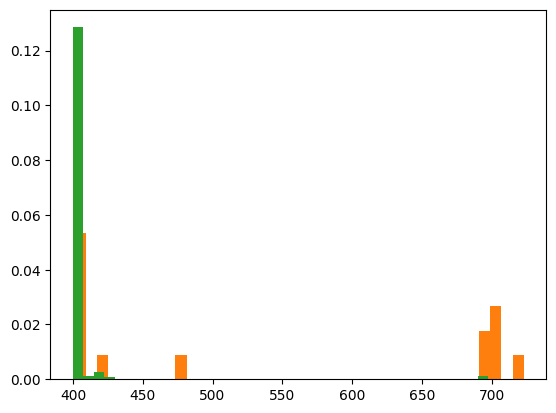

In [40]:
plt.hist(X[featureScores.nlargest(10,'Score').Feature.values[0]][y==0],bins=40,density=True);
plt.hist(X[featureScores.nlargest(10,'Score').Feature.values[0]][y==1],bins=40,density=True);
plt.hist(X[featureScores.nlargest(10,'Score').Feature.values[0]][y==0],bins=40,density=True);


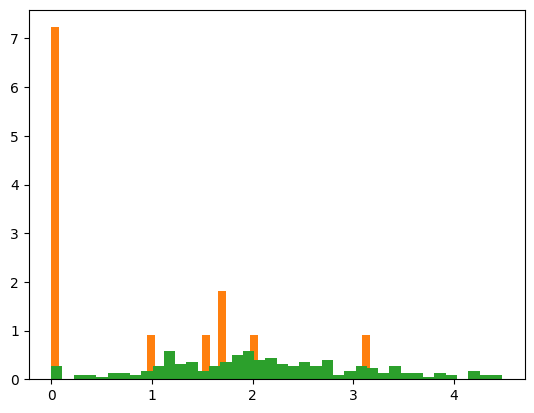

In [41]:
i=2

plt.hist(X[featureScores.nlargest(10,'Score').Feature.values[i]][y==0],bins=40,density=True);
plt.hist(X[featureScores.nlargest(10,'Score').Feature.values[i]][y==1],bins=40,density=True);
plt.hist(X[featureScores.nlargest(10,'Score').Feature.values[i]][y==0],bins=40,density=True);

In [42]:
featureScores.nlargest(10,'Score').Feature

8                           mean_Grid voltage (V)
88                   std_Nacelle temperature (°C)
82          std_Transformer cell temperature (°C)
75       std_Ambient temperature (converter) (°C)
79           std_Nacelle ambient temperature (°C)
84                        std_Gearbox speed (RPM)
76                          std_Rotor speed (RPM)
69                        std_Generator RPM (RPM)
72    std_Generator bearing rear temperature (°C)
67                    std_Rotor bearing temp (°C)
Name: Feature, dtype: object

In [55]:
set(featureScores.nlargest(10,'Score').Feature)

{'mean_Grid voltage (V)',
 'std_Ambient temperature (converter) (°C)',
 'std_Gearbox speed (RPM)',
 'std_Generator RPM (RPM)',
 'std_Generator bearing rear temperature (°C)',
 'std_Nacelle ambient temperature (°C)',
 'std_Nacelle temperature (°C)',
 'std_Rotor bearing temp (°C)',
 'std_Rotor speed (RPM)',
 'std_Transformer cell temperature (°C)'}

In [104]:
sel_features = {'mean_Grid voltage (V)',
# 'std_Ambient temperature (converter) (°C)',
 'std_Gearbox speed (RPM)',
 'std_Generator RPM (RPM)',
# 'std_Nacelle ambient temperature (°C)',
 'std_Rotor speed (RPM)',}



feature_sel = X.columns.isin(sel_features)

X_subsel = X.loc[:,feature_sel]

In [105]:
from sklearn.linear_model import LogisticRegression


In [136]:
#logreg = LogisticRegression()
logreg = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the training data
logreg.fit(X_subsel, y)

# Now, predict the outcomes for the test data
y_pred_proba = logreg.predict_proba(X_subsel)[:,0]

y_pred = logreg.predict(X_subsel)

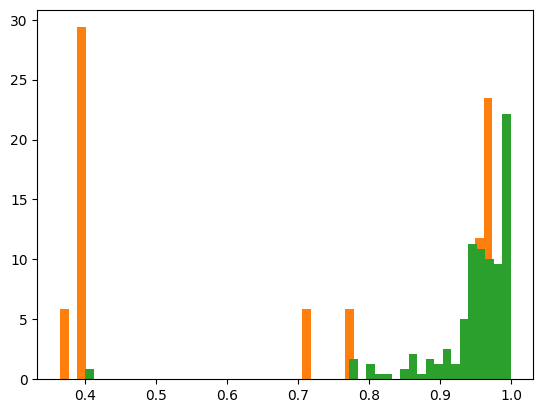

In [137]:
plt.hist(y_pred_proba[y==0],bins=50,density=True);

plt.hist(y_pred_proba[y==1],bins=50,density=True);

plt.hist(y_pred_proba[y==0],bins=50,density=True);


In [138]:
logreg.coef_

array([[ 0.00590392,  0.01075968,  0.        , -0.01850403]])

In [139]:
X_subsel.columns

Index(['mean_Grid voltage (V)', 'std_Generator RPM (RPM)',
       'std_Rotor speed (RPM)', 'std_Gearbox speed (RPM)'],
      dtype='object')

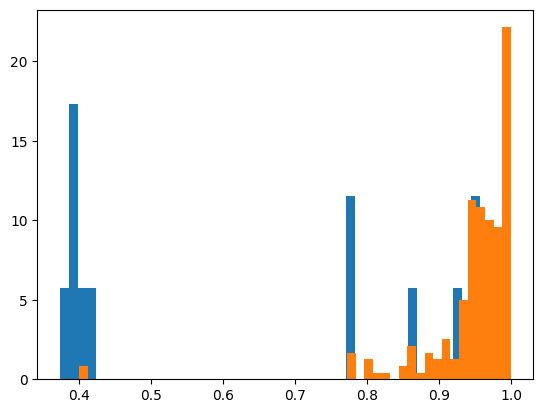

In [147]:
feature_sel = test_df_72.columns.isin(sel_features)

X_72 = test_df_72.loc[:,feature_sel]

y_pred_proba_72 = logreg.predict_proba(X_72)[:,0]
y_pred_proba_72
plt.hist(y_pred_proba_72,bins=50,density=True);
plt.hist(y_pred_proba[y==0],bins=50,density=True);

In [144]:
y_pred_proba_72

array([0.77534562, 0.39136823, 0.39405814, 0.39932542, 0.96567371,
       0.99347278, 0.41138374, 0.8691788 , 0.9516628 , 0.77534562,
       0.95132934, 0.39521058, 0.37376551, 0.92827931])

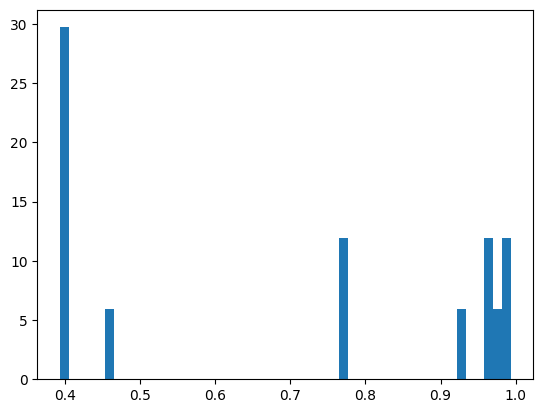

In [141]:
feature_sel = test_df_96.columns.isin(sel_features)

X_96 = test_df_96.loc[:,feature_sel]

y_pred_proba_96 = logreg.predict_proba(X_96)[:,0]
y_pred_proba_96
plt.hist(y_pred_proba_96,bins=50,density=True);


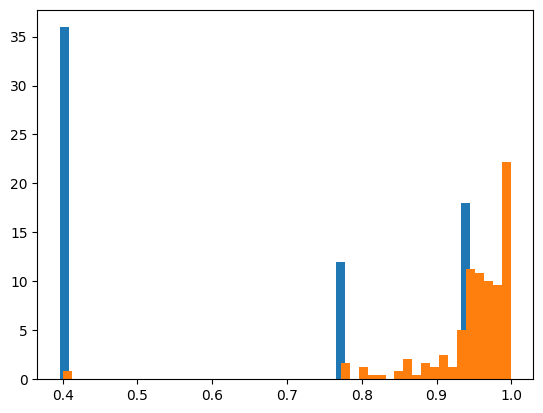

In [151]:
feature_sel = test_df_120.columns.isin(sel_features)

X_120 = test_df_120.loc[:,feature_sel]

y_pred_proba_120 = logreg.predict_proba(X_120)[:,0]
y_pred_proba_120
plt.hist(y_pred_proba_120,bins=50,density=True);
plt.hist(y_pred_proba[y==0],bins=50,density=True);

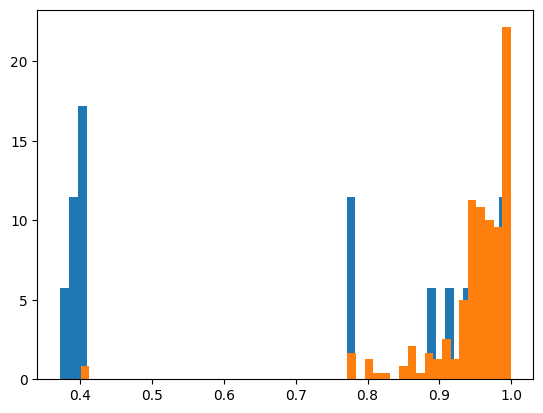

In [152]:
feature_sel = test_df_144.columns.isin(sel_features)

X_144 = test_df_144.loc[:,feature_sel]

y_pred_proba_144 = logreg.predict_proba(X_144)[:,0]
y_pred_proba_144
plt.hist(y_pred_proba_144,bins=50,density=True);
plt.hist(y_pred_proba[y==0],bins=50,density=True);

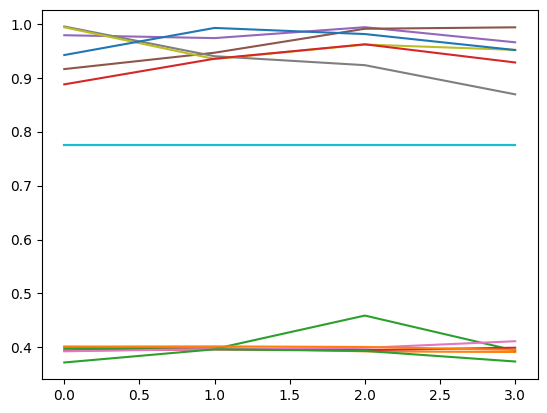

In [153]:
for d in zip(y_pred_proba_144,y_pred_proba_120,y_pred_proba_96,y_pred_proba_72):
    plt.plot(d)